In [114]:
import os
import pickle
import sys

sys.path.append(sys.path[0] + "/../..")  # Adds higher directory to python modules path.

import math
import numpy as np
import scipy
from Functions import renormalize, scomplex, plotting, support
import matplotlib.pyplot as plt
from scipy.stats import entropy as sp_entropy
import networkx as nx
import sklearn
from sklearn import cluster
import seaborn as sns
import powerlaw as pwl
plt.rcParams["text.usetex"] = True

import matplotlib.colors as mcolors
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage

from matplotlib.colors import LinearSegmentedColormap

#colors = list(mcolors.CSS4_COLORS)
#colors = colors + colors
colors = ["#071C56","#06418F","#2B589F","#5A5389","#7F588D","#533262","#B45389","#D75F78","#FDA599","#A40237"]
colors = colors + colors + colors + colors 
cmap = LinearSegmentedColormap.from_list("my_sas",colors)


In [124]:
# Triangle Tree
edges = [(0,1),(1,2),(0,2)]
new_boundary = [0,1,2]
n = 3
steps = 4
for s in range(steps):
    boundary = new_boundary
    new_boundary = []
    for node in boundary:
        new_boundary.append(n)
        new_boundary.append(n+1)
        edges.append((node,n))
        edges.append((node,n+1))
        edges.append((n,n+1))
        n += 2
G = nx.from_edgelist(edges)

In [75]:
# Tetrahedron tree attach through edges
edges = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
new_boundary = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
n = 4
steps = 3
for s in range(steps):
    #boundary = new_boundary
    #new_boundary = []
    boundary = edges.copy()
    for ed in boundary:
        edges.append((ed[0],n))
        edges.append((ed[0],n+1))
        edges.append((ed[1],n))
        edges.append((ed[1],n+1))
        edges.append((n,n+1))
        #new_boundary.append((ed[0],n))
        #new_boundary.append((ed[0],n+1))
        #new_boundary.append((ed[1],n))
        #new_boundary.append((ed[1],n+1))
        #new_boundary.append((n,n+1))
        n += 2
G = nx.from_edgelist(edges)

In [17]:
# Pseudofractal

def pseudofractal(steps):
    edges = [(0,1),(1,2),(0,2)]
    n = 3
    for s in range(steps):
        boundary = edges.copy()
        for ed in boundary:
            edges.append((ed[0],n))
            edges.append((ed[1],n))
            n += 1

    G = nx.from_edgelist(edges)
    sc = scomplex.convert_graph_to_sc(G)
    return sc


In [137]:
# Triangle Tree 2
edges = [(0,1),(1,2),(0,2)]
new_boundary = edges.copy()
n = 3
steps = 2
for s in range(steps):
    boundary = new_boundary
    new_boundary = []
    for ed in boundary:
        edges.append((ed[0],n))
        edges.append((ed[1],n))
        new_boundary.append((ed[0],n))
        new_boundary.append((ed[1],n))
        n += 1

G = nx.from_edgelist(edges)
sc = scomplex.convert_graph_to_sc(G)


In [93]:
# C. Elegans
f = open("CaenorhabditisElegans_lcb_hq.txt","r")
i = 0
edges = []
for line in f:
    if i != 0:
        words = line.split()
        edges.append((words[0],words[1]))
    else:
        i += 1
f.close()
G = nx.from_edgelist(edges)
G = nx.convert_node_labels_to_integers(G)
G.remove_edges_from(nx.selfloop_edges(G))
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])

In [157]:
def sierpinski(steps):
    edges = [(0,1),(1,2),(0,2)]
    boundary = [0,1,2]
    G = nx.from_edgelist(edges)

    for s in range(steps):
        H = G
        K = G
        GH = nx.union(G,H,rename = ("G","H"))
        GHK = nx.union(GH,K,rename = ("","K"))
        GHK = nx.contracted_nodes(GHK, f"G{boundary[1]}", f"H{boundary[0]}")
        GHK = nx.contracted_nodes(GHK, f"H{boundary[2]}", f"K{boundary[1]}")
        GHK = nx.contracted_nodes(GHK, f"G{boundary[2]}", f"K{boundary[0]}")
        G = GHK
        boundary = [f"G{boundary[0]}",f"H{boundary[1]}",f"K{boundary[2]}"]
        G = nx.convert_node_labels_to_integers(G, first_label=0, ordering='default', label_attribute="old")
        map = nx.get_node_attributes(G,"old")
        inv_map = {v: k for k, v in map.items()}
        boundary = [inv_map[boundary[i]] for i in range(3)]
        
    sc = scomplex.convert_graph_to_sc(G)
    return sc


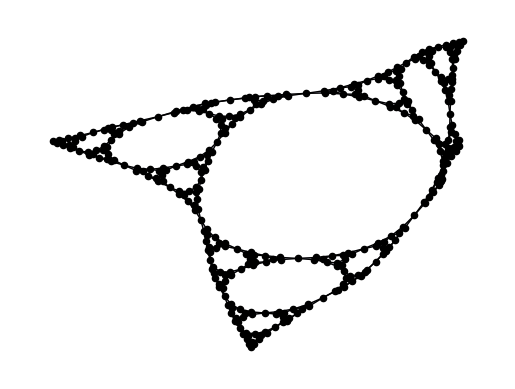

In [176]:

#G = nx.dorogovtsev_goltsev_mendes_graph(4)
#G = nx.random_tree(200, seed=10)
#G = nx.stochastic_block_model([40,40],[[0.3,0.02],[0.02,0.3]])

#G = nx.from_edgelist(edges)
#sc = scomplex.convert_graph_to_sc(G)

#sc  = scomplex.generate_fractal_cycle([20,40,60,5],0.0,20)
#sc = scomplex.generate_hlattice(12,12,0)
#sc = scomplex.NGF(2,100,1,1)
#sc = scomplex.generate_bridged_communities(50,50,0.04,0.04,10)
sc = sierpinski(5)

f,ax = plt.subplots(1,1)
plotting.plot_complex(sc,ax = ax,face_color=[colors[3]],layout = "spring", node_size=20)


In [165]:
d = 2 # Dimension
N = 1000 # Number of nodes
s = -1 # Flavour
nrep = 1 # Repetitions

sp_heats = [np.zeros(149),np.zeros(149),np.zeros(149),np.zeros(149),np.zeros(149)]
for r in range(nrep):
    print(r)
    #sc = scomplex.NGF(d,N,s,0.6)
    sc = sierpinski(6)
    B1, B2, B3, __, edge_dict, face_dict, tet_dict = scomplex.boundary_matrices_3(sc)
    L0 = (B1@B1.T).todense()
    L1d = (B1.T@B1).todense()
    L1u = (B2@B2.T).todense()
    L1 = L1d + L1u
    L2 = (B2.T@B2).todense()
    L1dR = -np.abs(L1d - np.diag(np.diag(L1d))) + np.diag(np.array(np.sum(np.abs(L1d - np.diag(np.diag(L1d))),0))[0])
    L1uR = -np.abs(L1u - np.diag(np.diag(L1u))) + np.diag(np.array(np.sum(np.abs(L1u - np.diag(np.diag(L1u))),0))[0])
    L1R = -np.abs(L1 - np.diag(np.diag(L1))) + np.diag(np.array(np.sum(np.abs(L1 - np.diag(np.diag(L1))),0))[0])
    L2R = -np.abs(L2 - np.diag(np.diag(L2))) + np.diag(np.array(np.sum(np.abs(L2 - np.diag(np.diag(L2))),0))[0])
    Laps = [L0,L1dR,L1uR,L1R,L2R]
    for i in range(5):
        speig,__ = np.linalg.eigh(Laps[i])
        spheat,tau_space, __ = renormalize.compute_heat(speig,-2,4,150)
        sp_heats[i] += spheat/nrep


0


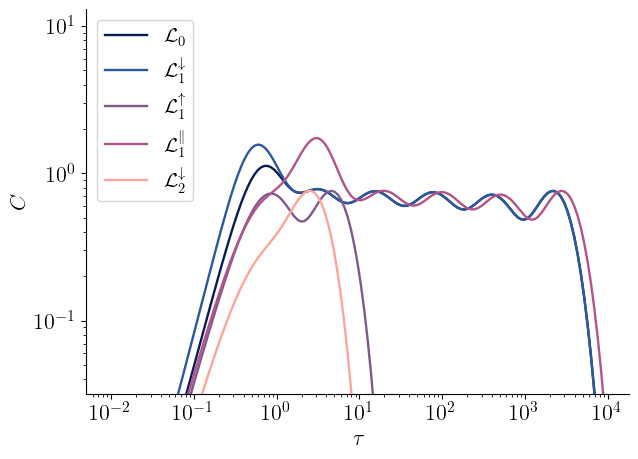

In [166]:
f,ax = plt.subplots(1,1,figsize = (7,5))
for i in range(5):
    ax.semilogx(tau_space,sp_heats[i],color = colors[int(np.floor(2*i))],linewidth = 1.7)
ax.set_yscale("log")
ax.set_ylim([10**-1.5,13])
ax.legend([r"$\mathcal{L}_0$",r"$\mathcal{L}_1^{\downarrow}$",r"$\mathcal{L}_1^{\uparrow}$",r"$\mathcal{L}^\parallel_1$",r"$\mathcal{L}^\downarrow_2$"],fontsize = 15)
ax.set_xlabel(r"$\tau$",fontsize = 16)
ax.set_ylabel(r"$C$",fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
#ax.hlines(y = 1,xmin=5,xmax = 800,linestyles='--',color = [0.5,0.5,0.5])
sns.despine()
#plt.savefig(f'../../Tests/Diffusion_Laplacians/Heat_curves/NGFd{d}s{s}_nodes{N}.pdf')
plt.savefig(f'../../Tests/Diffusion_Laplacians/Heat_curves/sierpinski_d2_iterations6.pdf')

In [181]:
d = 2
s = -1
rep = 1
steps_list = [2,3,4,5,6]
sp_heats = [np.zeros(149) for i in range(len(steps_list))]

for i in range(len(steps_list)):
    steps = steps_list[i]
    N = steps
    for r in range(rep):
        print(f"{i}:{r}")
        #sc = pseudofractal(steps)
        #sc = scomplex.NGF(d,N,s,0.6)
        sc = sierpinski(steps)

        B1, B2, B3, __, edge_dict, face_dict, tet_dict = scomplex.boundary_matrices_3(sc)
        #L0 = (B1@B1.T).todense()
        #L1d = (B1.T@B1).todense()
        #L1u = (B2@B2.T).todense()
        #L1 = L1d + L1u
        L2d = (B2.T@B2).todense()
        #L2u = (B3@B3.T).todense()
        #L2 = L2d + L2u
        #L3d = (B3.T@B3).todense()

        #L1dR = make_diffusive(L1d)
        #L1uR = make_diffusive(L1u)
        #L1R = make_diffusive(L1)
        L2dR = make_diffusive(L2d)
        #L2uR = make_diffusive(L2u)
        #L2R = make_diffusive(L2)
        #L3dR = make_diffusive(L3d)
        speig,__ = np.linalg.eigh(L2dR)
        spheat,tau_space, __ = renormalize.compute_heat(speig,-3,4,150)
        sp_heats[i] += spheat/rep


0:0
1:0
2:0
3:0
4:0


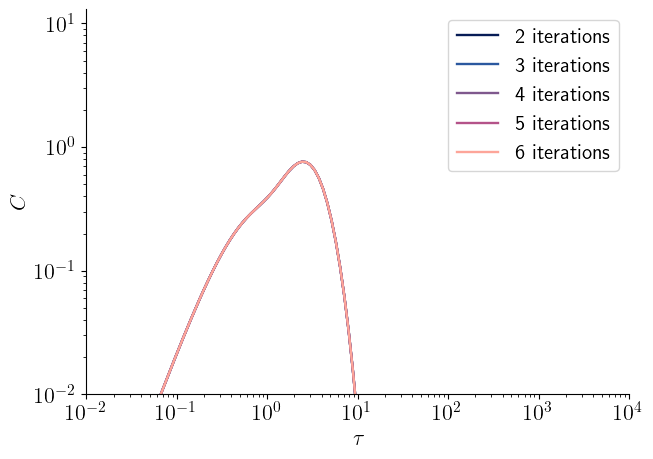

In [182]:
f,ax = plt.subplots(1,1,figsize = (7,5))
for i in range(len(steps_list)):
    ax.semilogx(tau_space,sp_heats[i],color = colors[int(np.floor(2*i))],linewidth = 1.7)
ax.set_yscale("log")
ax.set_ylim([10**-2,13])
ax.set_xlim([10**-2,10**4])
ax.legend([f"{steps_list[i]} iterations" for i in range(len(steps_list)) ], fontsize = 15)
#ax.legend([r"$\mathcal{L}_0$",r"$\mathcal{L}_1^{\downarrow}$",r"$\mathcal{L}_1^{\uparrow}$",r"$\mathcal{L}^\parallel_1$",r"$\mathcal{L}^\downarrow_2$"],fontsize = 15)
ax.set_xlabel(r"$\tau$",fontsize = 16)
ax.set_ylabel(r"$C$",fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
#ax.hlines(y = 1.25,xmin=5,xmax = 2000,linestyles='--',color = [0.5,0.5,0.5])
sns.despine()
#plt.savefig(f'../../Tests/Diffusion_Laplacians/Heat_curves/NGFd{d}s{s}_L1R_nodes.pdf')
plt.savefig(f'../../Tests/Diffusion_Laplacians/Heat_curves/sierpinski_L2dR_iterations.pdf')

In [59]:
def make_diffusive(L):
    Ldiff = -np.abs(L - np.diag(np.diag(L))) + np.diag(np.array(np.sum(np.abs(L - np.diag(np.diag(L))),0))[0])
    return Ldiff

In [84]:
d = 3 # Dimension
N = 500 # Number of nodes
s = 1 # Flavour
nrep = 20 # Repetitions

sp_heats = [np.zeros(149) for i in range(8)]
for r in range(nrep):
    print(r)
    sc = scomplex.NGF(d,N,s,0.6)
    B1, B2, B3, __, edge_dict, face_dict, tet_dict = scomplex.boundary_matrices_3(sc)
    L0 = (B1@B1.T).todense()
    L1d = (B1.T@B1).todense()
    L1u = (B2@B2.T).todense()
    L1 = L1d + L1u
    L2d = (B2.T@B2).todense()
    L2u = (B3@B3.T).todense()
    L2 = L2d + L2u
    L3d = (B3.T@B3).todense()

    L1dR = make_diffusive(L1d)
    L1uR = make_diffusive(L1u)
    L1R = make_diffusive(L1)
    L2dR = make_diffusive(L2d)
    L2uR = make_diffusive(L2u)
    L2R = make_diffusive(L2)
    L3dR = make_diffusive(L3d)

    Laps = [L0,L1dR,L1uR,L1R,L2dR,L2uR,L2R,L3dR]
    for i in range(8):
        speig,__ = np.linalg.eigh(Laps[i])
        spheat,tau_space, __ = renormalize.compute_heat(speig,-3,4,150)
        sp_heats[i] += spheat/nrep


0


/Users/marconurisso/Desktop/Work/Simplicial_Renormalization/HodgeLaplacianRenorm/hodge_renormalization/Hodge_renorm/Experiments_setups/Notebooks/../../Functions/renormalize.py:305: RuntimeWarning: overflow encountered in exp
  mu[i] = 1 / np.sum(np.exp(-tau * (D - D[i])))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


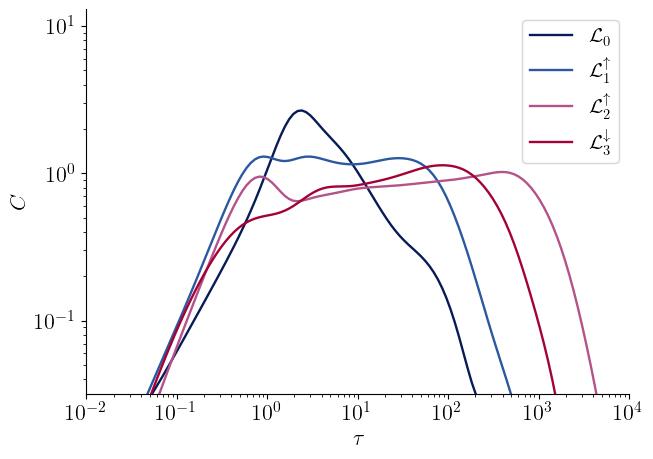

In [98]:
f,ax = plt.subplots(1,1,figsize = (7,5))
idxs = [0,2,5,7]
for i in idxs:
    ax.semilogx(tau_space,sp_heats[i],color = colors[int(np.floor(i*1.3))],linewidth = 1.7)
ax.set_yscale("log")
ax.set_ylim([10**-1.5,13])
ax.set_xlim([10**-2,10**4])
leg = [r"$\mathcal{L}_0$",r"$\mathcal{L}_1^{\downarrow}$",r"$\mathcal{L}_1^{\uparrow}$",r"$\mathcal{L}^\parallel_1$",r"$\mathcal{L}^\downarrow_2$",r"$\mathcal{L}^\uparrow_2$",r"$\mathcal{L}_2$",r"$\mathcal{L}^\downarrow_3$"]
ax.legend([leg[id] for id in idxs],fontsize = 15)
ax.set_xlabel(r"$\tau$",fontsize = 16)
ax.set_ylabel(r"$C$",fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
#ax.hlines(y = 1,xmin=5,xmax = 800,linestyles='--',color = [0.5,0.5,0.5])
sns.despine()
plt.savefig(f'../../Tests/Diffusion_Laplacians/Heat_curves/NGFd{d}s{s}_nodes{N}.pdf')
#plt.savefig(f'../../Tests/Diffusion_Laplacians/Heat_curves/sas.pdf')